In [71]:
import csv

import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split

RANDOM_SEED = 42

# 各パス指定

In [72]:
dataset = 'model/point_history_classifier/point_history.csv'
model_save_path = 'model/point_history_classifier/point_history_classifier.keras'

# 分類数設定

In [73]:
NUM_CLASSES = 3

# 入力長

In [74]:
TIME_STEPS = 16
DIMENSION = 4

# 学習データ読み込み

In [75]:
X_dataset = np.loadtxt(dataset, delimiter=',', dtype='float32', usecols=list(range(1, (TIME_STEPS * DIMENSION) + 1)))

In [76]:
y_dataset = np.loadtxt(dataset, delimiter=',', dtype='int32', usecols=(0))

In [77]:
X_train, X_test, y_train, y_test = train_test_split(X_dataset, y_dataset, train_size=0.75, random_state=RANDOM_SEED)

# モデル構築

In [78]:
use_lstm = False
model = None

if use_lstm:
    model = tf.keras.models.Sequential([
        tf.keras.layers.InputLayer(input_shape=(TIME_STEPS * DIMENSION, )),
        tf.keras.layers.Reshape((TIME_STEPS, DIMENSION), input_shape=(TIME_STEPS * DIMENSION, )), 
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.LSTM(16, input_shape=[TIME_STEPS, DIMENSION]),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(10, activation='relu'),
        tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
    ])
else:
    model = tf.keras.models.Sequential([
        tf.keras.layers.InputLayer(input_shape=(TIME_STEPS * DIMENSION, )),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(24, activation='relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(10, activation='relu'),
        tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
    ])

In [79]:
model.summary()  # tf.keras.utils.plot_model(model, show_shapes=True)

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout_8 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 24)             │         1,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 24)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 10)             │           250 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 3)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,843 (7.20 KB)

 Trainable params: 1,843 (7.20 KB)

 Non-trainable params: 0 (0.00 B)

In [80]:
# モデルチェックポイントのコールバック
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    model_save_path, verbose=1, save_weights_only=False)
# 早期打ち切り用コールバック
es_callback = tf.keras.callbacks.EarlyStopping(patience=20, verbose=1)

In [81]:
# モデルコンパイル
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# モデル訓練

In [82]:
model.fit(
    X_train,
    y_train,
    epochs=1000,
    batch_size=128,
    validation_data=(X_test, y_test),
    callbacks=[cp_callback, es_callback]
)

Epoch 1/1000
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4359 - loss: 1.0842   
Epoch 1: saving model to model/point_history_classifier/point_history_classifier.keras
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.4369 - loss: 1.0839 - val_accuracy: 0.4958 - val_loss: 1.0429
Epoch 2/1000
 1/34 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.5781 - loss: 1.0199
Epoch 2: saving model to model/point_history_classifier/point_history_classifier.keras
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5227 - loss: 1.0249 - val_accuracy: 0.5042 - val_loss: 0.9699
Epoch 3/1000
 1/34 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.5156 - loss: 0.9994
Epoch 3: saving model to model/point_history_classifier/point_history_classifier.keras
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5343 - loss: 0.9622 - val_accuracy: 0.5042 - val_loss: 0.8905
Epoch 4/1000
 1/34 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - accuracy: 0.5234 - loss: 0.9355
Epoch 4: saving model to model/point_history

In [83]:
# 保存したモデルのロード
model = tf.keras.models.load_model(model_save_path)

In [84]:
# 推論テスト
predict_result = model.predict(np.array([X_test[0]]))
print(np.squeeze(predict_result))
print(np.argmax(np.squeeze(predict_result)))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
[0.83300185 0.1363737  0.03062442]
0


# 混同行列

45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 955us/step


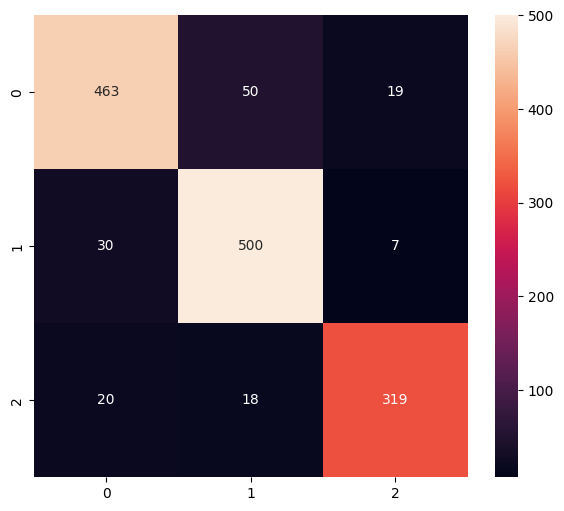

Classification Report
              precision    recall  f1-score   support

           0       0.90      0.87      0.89       532
           1       0.88      0.93      0.90       537
           2       0.92      0.89      0.91       357

    accuracy                           0.90      1426
   macro avg       0.90      0.90      0.90      1426
weighted avg       0.90      0.90      0.90      1426



In [85]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

def print_confusion_matrix(y_true, y_pred, report=True):
    labels = sorted(list(set(y_true)))
    cmx_data = confusion_matrix(y_true, y_pred, labels=labels)
    
    df_cmx = pd.DataFrame(cmx_data, index=labels, columns=labels)
 
    fig, ax = plt.subplots(figsize=(7, 6))
    sns.heatmap(df_cmx, annot=True, fmt='g' ,square=False)
    ax.set_ylim(len(set(y_true)), 0)
    plt.show()
    
    if report:
        print('Classification Report')
        print(classification_report(y_test, y_pred))

Y_pred = model.predict(X_test)
y_pred = np.argmax(Y_pred, axis=1)

print_confusion_matrix(y_test, y_pred)

# Tensorflow-Lite用のモデルへ変換

In [86]:
# 推論専用のモデルとして保存
model.save(model_save_path, include_optimizer=False)
model = tf.keras.models.load_model(model_save_path)

In [87]:
tflite_save_path = 'model/point_history_classifier/point_history_classifier.tflite'

In [88]:
# モデルを変換(量子化
converter = tf.lite.TFLiteConverter.from_keras_model(model)  # converter = tf.lite.TFLiteConverter.from_saved_model(saved_model_path)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_quantized_model = converter.convert()

open(tflite_save_path, 'wb').write(tflite_quantized_model)

INFO:tensorflow:Assets written to: C:\Users\DIOGOL~1\AppData\Local\Temp\tmp3bnsy_h6\assets


INFO:tensorflow:Assets written to: C:\Users\DIOGOL~1\AppData\Local\Temp\tmp3bnsy_h6\assets


Saved artifact at 'C:\Users\DIOGOL~1\AppData\Local\Temp\tmp3bnsy_h6'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 64), dtype=tf.float32, name='input_layer_4')
Output Type:
  TensorSpec(shape=(None, 3), dtype=tf.float32, name=None)
Captures:
  1726285674640: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1726285675216: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1726285667536: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1726249897616: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1726249896464: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1726249898192: TensorSpec(shape=(), dtype=tf.resource, name=None)


5240

# 推論テスト

In [89]:
interpreter = tf.lite.Interpreter(model_path=tflite_save_path)
interpreter.allocate_tensors()

In [90]:
# 入出力テンソルを取得
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()
print(input_details)

[{'name': 'serving_default_input_layer_4:0', 'index': 0, 'shape': array([ 1, 64]), 'shape_signature': array([-1, 64]), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}]


In [91]:
interpreter.set_tensor(input_details[0]['index'], np.array([X_test[0]]))

In [92]:
%%time
# 推論実施
interpreter.invoke()
tflite_results = interpreter.get_tensor(output_details[0]['index'])

CPU times: total: 0 ns
Wall time: 0 ns


In [93]:
print(np.squeeze(tflite_results))
print(np.argmax(np.squeeze(tflite_results)))

[0.8337086  0.1357306  0.03056081]
0
